<h2>Проект: предсказания победителя в онлайн-игре</h2>
<h3>Решение: Власов Александр</h3>

In [218]:
import numpy as np
import pandas as pd
import datetime

from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

%matplotlib inline

<h1><b>Подход 1: градиентный бустинг "в лоб"</b></h1>

<h3><b>1. Считайте таблицу с признаками из файла features.csv</b></h3>
Удалите признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке).

In [219]:
features = pd.read_csv('./features.csv', index_col='match_id')

features.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


<h2>Удалим столбцы содержащие информацию об итогах матча:</h2>
<b>duration</b>: длительность<br>
<b>tower_status_radiant:</b> состояние башен Radiant<br>
<b>tower_status_dire:</b> состояние башен Dire<br>
<b>barracks_status_radiant:</b>состояние барраков Radiant<br>
<b>barracks_status_dire:</b> состояние барраков Dire<br>

In [220]:
features.drop([
    "duration",
    "tower_status_radiant",
    "tower_status_dire",
    "barracks_status_radiant",
    "barracks_status_dire",
], axis=1, inplace=True)

<h2><b>2. Проверьте выборку на наличие пропусков с помощью функции count(), которая для каждого столбца показывает число заполненных значений.</b></h2> Много ли пропусков в данных? Запишите названия признаков, имеющих пропуски, и попробуйте для любых двух из них дать обоснование, почему их значения могут быть пропущены.

In [221]:
na_counter = features.isnull().sum()
na_counter.sort_values(ascending=False)[na_counter>0]/len(features) #с помощью na_counter>0 ищбавляемся от столбцов не содержащих пропуски, 

first_blood_player2            0.452402
radiant_flying_courier_time    0.282619
dire_flying_courier_time       0.268415
first_blood_time               0.201100
first_blood_team               0.201100
first_blood_player1            0.201100
dire_bottle_time               0.166029
radiant_bottle_time            0.161380
radiant_first_ward_time        0.018883
dire_first_ward_time           0.018780
radiant_courier_time           0.007117
dire_courier_time              0.006953
dtype: float64

<b>first_blood_player2</b> в 45% игр только один игрок принимает участие в событии "первая кровь" <br>
<b>radiant_flying_courier_time</b> в 28% игр команда Radiant не приобретает "летающего курьера" до 5й минуты <br>
<b>dire_flying_courier_time</b> в 26% игр команда Dire не приобретает "летающего курьера" до 5й минуты <br>
<b>first_blood_time, first_blood_team, first_blood_player1</b> в 20% игр доя 5й минуты не происходит события "первая кровь", соответственно нет данных по этим показателям<br>
<b>dire_bottle_time, radiant_bottle_time</b> в 16% игр ни один игрок команды Dire не покупает bottle до 5й минуты, аналогично для команды Radiant<br>
<b>radiant_first_ward_time, dire_first_ward_time</b> в 1.8% игр ни один игрок команды Radiant не устанавливает ward до 5й минуты, аналогично для команды Dire<br>
<b>radiant_courier_time, dire_courier_time</b> менее чем в 1% игр ни один игрок команды Radiant не приобретает courier до 5й минуты, аналогично для команды Dire<br>


<h2><b>3. Замените пропуски на нули с помощью функции fillna()</b></h2>
На самом деле этот способ является предпочтительным для логистической регрессии, поскольку он позволит пропущенному значению не вносить никакого вклада в предсказание. Для деревьев часто лучшим вариантом оказывается замена пропуска на очень большое или очень маленькое значение — в этом случае при построении разбиения вершины можно будет отправить объекты с пропусками в отдельную ветвь дерева. Также есть и другие подходы — например, замена пропуска на среднее значение признака. Мы не требуем этого в задании, но при желании попробуйте разные подходы к обработке пропусков и сравните их между собой.

In [222]:
features.fillna(0, inplace = True)

## Определим набор учебных данных

In [223]:
X_train = features.drop("radiant_win", axis=1)
X_train.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,0,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,0,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,1,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,0,-30.0,124.0,-80.0,184.0,0,4,2,0,27.0
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,0,46.0,182.0,-80.0,225.0,6,3,3,0,-16.0


<h2><b> 4. Обозначим целевую переменную </b></h2>
Столбец <b>radiant_win</b>, содержащий результат матча вынесем в целевую переменную <b>y_train</b>

In [224]:
y_train = features["radiant_win"]

<h2><b>5. Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки".</b></h2>

Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (KFold), не забудьте перемешать при этом выборку (shuffle=True), поскольку данные в таблице отсортированы по времени, и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества. Оцените качество градиентного бустинга (GradientBoostingClassifier) с помощью данной кросс-валидации, попробуйте при этом разное количество деревьев (как минимум протестируйте следующие значения для количества деревьев: 10, 20, 30). Долго ли настраивались классификаторы? Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении?

In [225]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [226]:
def score_gradient_boost(x, y):
    scores = {}

    for number_of_trees in [10, 20, 30, 50, 100, 200, 300]:
        print('__________________________________')
        print(f"Количество деревьев: {number_of_trees}")
        clf = GradientBoostingClassifier(n_estimators=number_of_trees, random_state=42)
        
        start_time = datetime.datetime.now()
        score = cross_val_score(clf, x, y, cv=cv, scoring="roc_auc", n_jobs=-1).mean() 
        
        print(f"Оценка: {score:.3f}")
        print(f"Время: {datetime.datetime.now() - start_time}")

        scores[number_of_trees] = score
        print()
        
    return pd.Series(scores)

__________________________________
Количество деревьев: 10
Оценка: 0.665
Время: 0:00:09.414048

__________________________________
Количество деревьев: 20
Оценка: 0.682
Время: 0:00:16.657017

__________________________________
Количество деревьев: 30
Оценка: 0.690
Время: 0:00:23.734276

__________________________________
Количество деревьев: 50
Оценка: 0.697
Время: 0:00:39.394696

__________________________________
Количество деревьев: 100
Оценка: 0.706
Время: 0:01:19.870684

__________________________________
Количество деревьев: 200
Оценка: 0.714
Время: 0:02:42.318247

__________________________________
Количество деревьев: 300
Оценка: 0.717
Время: 0:03:58.610863



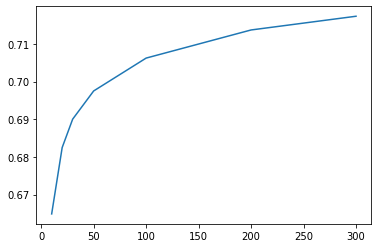

In [227]:
scores = score_gradient_boost(X_train, y_train)
scores.plot()

Кросс-валидация для градиентного бустинга с 30 деревьями заняла 23.73 секунды. Показатель метрики качества AUC-ROC составил 0.69</br>
С увеличением количества деревьев показатель метрики качества стремится к 0.72.</br>
Стоит отметить, что увеличение количества деревьев в 10 раз относительно 30 дало прирост качества на 3,7% (1-0.69/0.717), при этом затрачиваемое время увеличилось почти в 10 раз (23.89 секунд против 238.61).- на мой взгляд прирост не оправдывает затраты</br>
Для ускорения обучения можно использовать случайно сформированную ее часть. Также можно уменьшить значение определяющее глубину деревьев (max_depth).

# Подход 2: логистическая регрессия

## Оцените качество логистической регрессии (sklearn.linear_model.LogisticRegression с L2-регуляризацией) с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга.

Подберите при этом лучший параметр регуляризации (C). Какое наилучшее качество у вас получилось? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

In [228]:
scaler = StandardScaler()
X_train = features.drop("radiant_win", axis=1)
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)

In [229]:
def score_logistic_regression(x, y):
    scores = {}

    for power in range(-6, 1):
        print('__________________________________')
        c = 10.0 ** power
        print(f"Параметр регуляризации (C): {c}")
        clf = LogisticRegression(C=c, random_state=42)

        start_time = datetime.datetime.now()
        score = cross_val_score(clf, x, y, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
        
        print(f"Оценка: {score:.3f}")
        print(f"Время: {datetime.datetime.now() - start_time}")

        scores[power] = score
        print()

    return pd.Series(scores)

__________________________________
Параметр регуляризации (C): 1e-06
Оценка: 0.688
Время: 0:00:01.063408

__________________________________
Параметр регуляризации (C): 1e-05
Оценка: 0.695
Время: 0:00:00.942928

__________________________________
Параметр регуляризации (C): 0.0001
Оценка: 0.711
Время: 0:00:01.078509

__________________________________
Параметр регуляризации (C): 0.001
Оценка: 0.716
Время: 0:00:01.783039

__________________________________
Параметр регуляризации (C): 0.01
Оценка: 0.717
Время: 0:00:02.462848

__________________________________
Параметр регуляризации (C): 0.1
Оценка: 0.717
Время: 0:00:02.375966

__________________________________
Параметр регуляризации (C): 1.0
Оценка: 0.717
Время: 0:00:02.375078



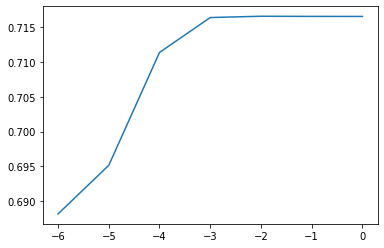

In [230]:
scores = score_logistic_regression(X_train, y_train)
scores.plot()

Наилучшее значение показателя AUC-ROC составляет 0,717 и достигается при параметре реугляризации C = 0.01.
Для градиентного бустинга аналогичное значение достигается при использовании более 200 деревьев, и затрачивая в разы больше времени. 
Совпадение значений результатов оценок градиентного бустинга и логистической регрессии свидетельсвует о линейной зависимости между признаками в выборке и целевой переменной, следовательно использование логистической регрессии оптимально с точки зрения скорости и разрабатывать комбинированную модель нецелесообразно. 

## 2. Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей.
Категориальных признаков в этой задаче одиннадцать: lobby_type и r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero. Уберите их из выборки, и проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Изменилось ли качество? Чем вы можете это объяснить?

In [231]:
drop_columns = ["lobby_type"] + [f"r{i}_hero" for i in range (1, 6)] + [f"d{i}_hero" for i in range (1, 6)]
X_train.drop(drop_columns, axis=1, inplace=True)

__________________________________
Параметр регуляризации (C): 1e-06
Оценка: 0.688
Время: 0:00:00.937491

__________________________________
Параметр регуляризации (C): 1e-05
Оценка: 0.695
Время: 0:00:00.898617

__________________________________
Параметр регуляризации (C): 0.0001
Оценка: 0.711
Время: 0:00:01.014495

__________________________________
Параметр регуляризации (C): 0.001
Оценка: 0.716
Время: 0:00:01.558804

__________________________________
Параметр регуляризации (C): 0.01
Оценка: 0.717
Время: 0:00:02.252819

__________________________________
Параметр регуляризации (C): 0.1
Оценка: 0.717
Время: 0:00:02.198616

__________________________________
Параметр регуляризации (C): 1.0
Оценка: 0.717
Время: 0:00:02.220410



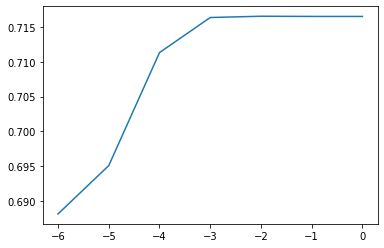

In [232]:
scores = score_logistic_regression(X_train, y_train)
scores.plot()

Удаление категориальных признаков не оказало влияние на качество модели. Такой результат можно объяснить отсутствием влияния этих признаков на результат, модель воспринимает их как шум.

## 3. На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду.
Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Выясните из данных, сколько различных идентификаторов героев существует в данной игре (вам может пригодиться фукнция unique или value_counts).

In [233]:
column_heroes = [f"r{i}_hero" for i in range (1, 6)] + [f"d{i}_hero" for i in range (1, 6)]
count_heroes = features[column_heroes]
max_id = max(np.unique(count_heroes))
count_heroes = len(np.unique(count_heroes))
print(f'Максимальный ID: {max_id} | Количество уникальных ID: {count_heroes}')

Максимальный ID: 112 | Количество уникальных ID: 108


In [234]:
def pick(data):
    X_pick = np.zeros((data.shape[0], max_id))

    for i, match_id in enumerate(data.index):
        for p in range(1, 6):
            X_pick[i, data.loc[match_id, f"r{p}_hero"] - 1] = 1
            X_pick[i, data.loc[match_id, f"d{p}_hero"] - 1] = -1

    return pd.DataFrame(X_pick, index=data.index, columns=[f"hero_{i}" for i in range(max_id)])

X_pick = pick(features)
X_pick.head()

,hero_0,hero_1,hero_2,hero_3,hero_4,hero_5,hero_6,hero_7,hero_8,hero_9,...,hero_102,hero_103,hero_104,hero_105,hero_106,hero_107,hero_108,hero_109,hero_110,hero_111
match_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [235]:
X_train = pd.concat([X_train, X_pick], axis=1)

## Проведите кросс-валидацию для логистической регрессии на новой выборке
с подбором лучшего параметра регуляризации. Какое получилось качество? Улучшилось ли оно? Чем вы можете это объяснить?

__________________________________
Параметр регуляризации (C): 1e-06
Оценка: 0.691
Время: 0:00:02.110598

__________________________________
Параметр регуляризации (C): 1e-05
Оценка: 0.699
Время: 0:00:01.875988

__________________________________
Параметр регуляризации (C): 0.0001
Оценка: 0.725
Время: 0:00:02.214080

__________________________________
Параметр регуляризации (C): 0.001
Оценка: 0.746
Время: 0:00:04.085042

__________________________________
Параметр регуляризации (C): 0.01
Оценка: 0.752
Время: 0:00:06.949399

__________________________________
Параметр регуляризации (C): 0.1
Оценка: 0.752
Время: 0:00:08.666813

__________________________________
Параметр регуляризации (C): 1.0
Оценка: 0.752
Время: 0:00:09.116635



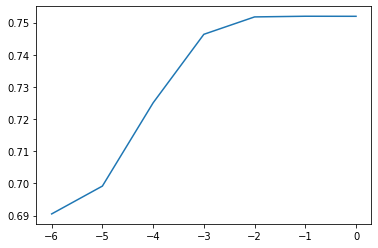

In [236]:
scores = score_logistic_regression(X_train, y_train)
scores.plot()

"Мешок слов" улучшил значение качества предсказаний до 0,752. Это объясняется тем, что теперь информация по героям является более осмысленной и интерпретируемой для модели.

## 6. Постройте предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей (лучшей с точки зрения AUC-ROC на кросс-валидации)
Убедитесь, что предсказанные вероятности адекватные — находятся на отрезке [0, 1], не совпадают между собой (т.е. что модель не получилась константной).

In [237]:
clf = LogisticRegression(C=0.01, random_state=42)
clf.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [238]:
features_test = pd.read_csv("./features_test.csv", index_col="match_id")
features_test.fillna(0, inplace=True)

In [239]:
X_test = pd.DataFrame(scaler.transform(features_test), index=features_test.index, columns=features_test.columns)
X_test.drop(drop_columns, axis=1, inplace=True)

X_pick = pick(features_test)
X_test = pd.concat([X_test, X_pick], axis=1)
X_test.head()

,start_time,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_level,r2_xp,...,hero_102,hero_103,hero_104,hero_105,hero_106,hero_107,hero_108,hero_109,hero_110,hero_111
match_id,,,,,,,,,,,,,,,,,,,,,
6,-2.528200,0.501314,-0.230161,-0.126909,-0.357459,-0.537757,1.017574,0.291758,-0.332256,-0.011207,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-2.527214,-1.297676,-1.195592,-1.245180,-1.131661,-0.537757,-0.578083,0.291758,0.578881,0.008600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,-2.525688,-1.297676,-0.851426,-0.732370,-1.131661,-0.537757,-0.578083,1.893320,-1.243393,-1.383288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13,-2.521671,-0.398181,-0.927319,-0.527677,-1.131661,0.968527,1.017574,1.092539,-1.243393,-0.931329,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
16,-2.520369,0.501314,0.045173,-1.049106,-0.799860,-0.537757,-0.578083,0.291758,1.490017,0.925122,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [240]:
predictions = pd.Series(clf.predict_proba(X_test)[:, 1])
print(f'Минимальное значение прогноза на тестовой выборке получилось: {round(min(predictions),5)}')
print(f'Максимальное значение прогноза на тестовой выборке получилось: {round(max(predictions),5)}')

Минимальное значение прогноза на тестовой выборке получилось: 0.00831
Максимальное значение прогноза на тестовой выборке получилось: 0.99588


Убедитесь, что предсказанные вероятности адекватные — находятся на отрезке [0, 1], не совпадают между собой (т.е. что модель не получилась константной).

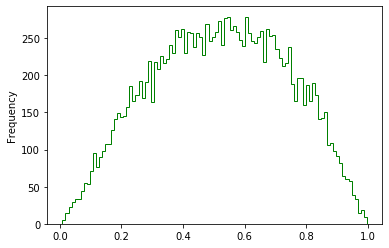

In [253]:
predictions.plot.hist(bins=100, histtype = "step", color = 'green')

Как видно на графике вероятности находятся в необхоимых пределах и не совпадают между собой